# Estimate model pollution and financial dependency with city mandate

# Objective(s)

**Business needs**

Estimate the SO2 emission as a function of financial ratio, policy mandate and a time break

**Description**

**Objective**

Test the coefficient sign and significant of the main variable, the triple interaction term: financial ratio, time break and policy mandate. 

Test only with financial ratio computed at the industry level → more observation 

**Tables**

1. Table 1: Baseline estimate, SO2 emission reduction and industry financial ratio

**Cautious**


# Metadata

* Key: nii81ldai42313s
* Parent key (for update parent):  
* Notebook US Parent (i.e the one to update): 
* Epic: Epic 2
* US: US 1
* Date Begin: 11/28/2020
* Duration Task: 1
* Description: Estimate the SO2 emission as a function of financial ratio, policy mandate and a time break
* Step type: Evaluate model
* Status: Active
* Source URL: US 01 Baseline financial ratio
* Task type: Jupyter Notebook
* Users: Thomas Pernet
* Watchers: Thomas Pernet
* User Account: https://468786073381.signin.aws.amazon.com/console
* Estimated Log points: 7
* Task tag: #econometrics,#financial-ratio,#policy,#so2
* Toggl Tag: #model-estimate
* current nb commits: 0
* Meetings:  
* Presentation:  
* Email Information:  
  * thread: Number of threads: 0(Default 0, to avoid display email)
  *  

# Input Cloud Storage [AWS/GCP]

## Table/file

* Origin: 
* Athena
* Name: 
* asif_city_industry_financial_ratio
* Github: 
  * https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/00_asif_financial_ratio.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'environment'
table = 'fin_dep_pollution_baseline'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )
dtypes

{'year': 'string',
 'period': 'string',
 'provinces': 'string',
 'cityen': 'string',
 'geocode4_corr': 'string',
 'tcz': 'string',
 'spz': 'string',
 'cic': 'string',
 'ind2': 'string',
 'short': 'string',
 'tso2': 'float',
 'tso2_mandate_c': 'float',
 'in_10_000_tonnes': 'float',
 'output': 'float',
 'employment': 'float',
 'sales': 'float',
 'working_capital_cit': 'float',
 'working_capital_ci': 'float',
 'working_capital_i': 'float',
 'asset_tangibility_cit': 'float',
 'asset_tangibility_ci': 'float',
 'asset_tangibility_i': 'float',
 'current_ratio_cit': 'float',
 'current_ratio_ci': 'float',
 'current_ratio_i': 'float',
 'cash_assets_cit': 'float',
 'cash_assets_ci': 'float',
 'cash_assets_i': 'float',
 'liabilities_assets_cit': 'float',
 'liabilities_assets_ci': 'float',
 'liabilities_assets_i': 'float',
 'return_on_asset_cit': 'float',
 'return_on_asset_ci': 'float',
 'return_on_asset_i': 'float',
 'sales_assets_cit': 'float',
 'sales_assets_ci': 'float',
 'sales_assets_i': 'flo

In [7]:
download_data = False

if download_data:
    filename = 'df_{}'.format(table)
    full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
            )
    s3.download_file(
        key = full_path_filename
    )
    path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [8]:
pd.DataFrame(schema)

,Name,Type,Comment
0,year,string,year from 2001 to 2007
1,period,string,"False if year before 2005 included, True if year 2006 and 2007"
2,provinces,string,
3,cityen,string,
4,geocode4_corr,string,
5,tcz,string,Two control zone policy city
6,spz,string,Special policy zone policy city
7,cic,string,4 digits industry
8,ind2,string,
9,short,string,


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [9]:
add_to_dic = True
if add_to_dic:
    with open('schema_table.json') as json_file:
        data = json.load(json_file)
    data['to_rename'] = []
    dic_rename = [
        ### control variables
        {
        'old':'output',
        'new':'\\text{output}_{cit}'
        },
        {
        'old':'employment',
        'new':'\\text{employment}_{cit}'
        },
       # {
       # 'old':'sales',
       # 'new':'\\text{sales}_{cit}'
       # },
        
        ### financial ratio
        #### Industry
        {
        'old':'working\_capital\_i',
        'new':'\\text{working capital}_i'
        },
        {
        'old':'asset\_tangibility\_i',
        'new':'\\text{asset tangibility}_i'
        },
        {
        'old':'current\_ratio\_i',
        'new':'\\text{current ratio}_i'
        },
        {
        'old':'cash\_assets\_i',
        'new':'\\text{cash assets}_i'
        },
        {
        'old':'liabilities\_assets\_i',
        'new':'\\text{liabilities assets}_i'
        },
        {
        'old':'return\_on\_asset\_i',
        'new':'\\text{return on asset}_i'
        },
        {
        'old':'sales\_assets\_i',
        'new':'\\text{sales assets}_i'
        },
        #### City-industry
        {
        'old':'working\_capital\_ci',
        'new':'\\text{working capital}_{ci}'
        },
        {
        'old':'asset\_tangibility\_ci',
        'new':'\\text{asset tangibility}_{ci}'
        },
        {
        'old':'current\_ratio\_ci',
        'new':'\\text{current ratio}_{ci}'
        },
        {
        'old':'cash\_assets\_ci',
        'new':'\\text{cash assets}_{ci}'
        },
        {
        'old':'liabilities\_assets\_ci',
        'new':'\\text{liabilities assets}_{ci}'
        },
        {
        'old':'return\_on\_asset\_ci',
        'new':'\\text{return on asset}_{ci}'
        },
        {
        'old':'sales\_assets\_ci',
        'new':'\\text{sales assets}_{ci}'
        },
        #### City-Industry-year
         {
        'old':'working\_capital\_cit',
        'new':'\\text{working capital}_{cit}'
        },
        {
        'old':'asset\_tangibility\_cit',
        'new':'\\text{asset tangibility}_{cit}'
        },
        {
        'old':'current\_ratio\_cit',
        'new':'\\text{current ratio}_{cit}'
        },
        {
        'old':'cash\_assets\_cit',
        'new':'\\text{cash assets}_{cit}'
        },
        {
        'old':'liabilities\_assets\_cit',
        'new':'\\text{liabilities assets}_{cit}'
        },
        {
        'old':'return\_on\_asset\_cit',
        'new':'\\text{return on asset}_{cit}'
        },
        {
        'old':'sales\_assets\_cit',
        'new':'\\text{sales assets}_{cit}'
        },
        #### 
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        {
        'old':'period',
        'new':'\\text{period}'
        },
        {
        'old':'tso2\_mandate\_c',
        'new':'\\text{policy mandate}_c'
        },
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)
    print(data)

{'to_remove': '', 'to_rename': [{'old': 'output', 'new': '\\text{output}_{cit}'}, {'old': 'employment', 'new': '\\text{employment}_{cit}'}, {'old': 'working\\_capital\\_i', 'new': '\\text{working capital}_i'}, {'old': 'asset\\_tangibility\\_i', 'new': '\\text{asset tangibility}_i'}, {'old': 'current\\_ratio\\_i', 'new': '\\text{current ratio}_i'}, {'old': 'cash\\_assets\\_i', 'new': '\\text{cash assets}_i'}, {'old': 'liabilities\\_assets\\_i', 'new': '\\text{liabilities assets}_i'}, {'old': 'return\\_on\\_asset\\_i', 'new': '\\text{return on asset}_i'}, {'old': 'sales\\_assets\\_i', 'new': '\\text{sales assets}_i'}, {'old': 'working\\_capital\\_ci', 'new': '\\text{working capital}_{ci}'}, {'old': 'asset\\_tangibility\\_ci', 'new': '\\text{asset tangibility}_{ci}'}, {'old': 'current\\_ratio\\_ci', 'new': '\\text{current ratio}_{ci}'}, {'old': 'cash\\_assets\\_ci', 'new': '\\text{cash assets}_{ci}'}, {'old': 'liabilities\\_assets\\_ci', 'new': '\\text{liabilities assets}_{ci}'}, {'old': 

# Models to estimate

The model to estimate is: 

## Fixed Effect

TABLE FIXED EFFECT


- FE NAME: `FE NAME IN TALBE`

In [10]:
import function.latex_beautify as lb

%load_ext autoreload
%autoreload 2

In [11]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "function/table_golatex.R"
source(path)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [12]:
path = '../../../00_Data_catalogue/temporary_local_data/df_fin_dep_pollution_baseline.csv'
df_final <- read_csv(path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE')
)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  provinces = col_character(),
  cityen = col_character(),
  short = col_character(),
  lower_location = col_character(),
  larger_location = col_character(),
  coastal = col_character()
)

See spec(...) for full column specifications.



In [13]:
head(df_final)

year,period,provinces,cityen,geocode4_corr,tcz,spz,cic,ind2,short,⋯,return_on_asset_i,sales_assets_cit,sales_assets_ci,sales_assets_i,lower_location,larger_location,coastal,fe_c_i,fe_t_i,fe_c_t
<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
2001,FALSE,Beijing,Beijing,1101,1,1,3110,31,Non-metallic Products,⋯,NA,NA,-5.30284,-0.83499,Coastal,Eastern,No,151,231,1
2001,FALSE,Beijing,Beijing,1101,1,1,3040,30,Plastics,⋯,4.98439,NA,13.05676,50.30100,Coastal,Eastern,No,147,225,1
2001,FALSE,Beijing,Beijing,1101,1,1,2415,24,"Education and Sport Activity""",⋯,NA,NA,52.91114,24.01365,Coastal,Eastern,No,96,143,1
2001,FALSE,Beijing,Beijing,1101,1,1,1522,15,Beverages,⋯,1.93081,NA,121.37017,-6.20469,Coastal,Eastern,No,47,60,1
2001,FALSE,Beijing,Beijing,1101,1,1,1521,15,Beverages,⋯,3.37134,NA,9.15685,2.70411,Coastal,Eastern,No,46,59,1
2001,FALSE,Beijing,Beijing,1101,1,1,2429,24,"Education and Sport Activity""",⋯,4.12041,NA,2.41882,5.51978,Coastal,Eastern,No,97,148,1


## Table 1: Baseline estimate, SO2 emission reduction and industry financial ratio, industry level

$$
\begin{aligned}
\text{SO2}_{cit}  &= \alpha \text{Financial ratio}_i \times \text{Period} \times \text{policy mandate}_c  + \gamma_{ci} + \gamma_{ti} +\gamma_{ct}  + \epsilon_{cit}
\end{aligned}
$$



* Column 1: working_capital_i
    * Expected sign: + -> Less constrain because more cash after meeting its bills
    * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`
* Column 2: asset_tangibility_i
    * Expected sign: + -> Less constrain because more liquid assets 
    * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`
* Column 3: current_ratio_i
    * Expected sign: + -> Less constrain because maximises current assets to payback current liabilities
    * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`
* Column 4: cash_assets_i
    * Expected sign: + -> Less constrain because large portion of cash hold
    * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`
* Column 5: liabilities_assets_i
   * Expected sign: - -> Large value indicates financed by creditors and not owners
   * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`
* Column 6: return_on_asset_i
    * Expected sign:  + -> Large values indicates good performances, hence more profit
    * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`
* Column 7: sales_assets_i
    * Expected sign: + -> Large value indicates good use of asset to generate sales
    * FE: 
        - fe 1: `ci`
        - fe 2: `ti`
        - fe 3: `ct`   
        
**Andersen results**

![](https://drive.google.com/uc?export=view&id=1HrqaA5NLRPjWk2lqvHyrZAjO3wSP5r-9)

In [14]:
t_0 <- felm(log(tso2) ~ working_capital_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ current_ratio_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~ cash_assets_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ liabilities_assets_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~ return_on_asset_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_6 <- felm(log(tso2) ~ sales_assets_i * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)


In [15]:
import os
try:
    os.remove("Tables/table_0.txt")
except:
    pass
try:
    os.remove("Tables/table_0.tex")
except:
    pass
try:
    os.remove("Tables/table_0.pdf")
except:
    pass

In [16]:
dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    
    c("City-time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5, t_6
),
    title="Baseline estimate, SO2 emission reduction and industry financial ratio, industry level",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name="Tables/table_0.txt"
)

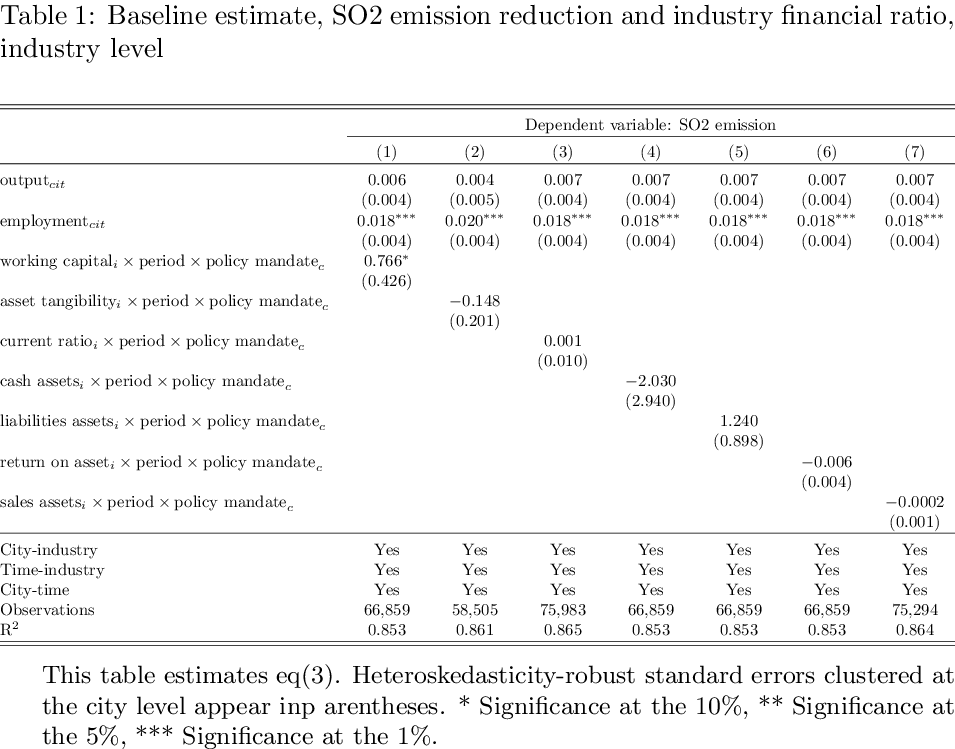

In [17]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = 0,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200)

## Table 2: Baseline estimate, SO2 emission reduction and industry financial ratio, city-industry level

$$
\begin{aligned}
\text{SO2}_{cit}  &= \alpha \text{Financial ratio}_ci \times \text{Period} \times \text{policy mandate}_c  + \gamma_{ci} + \gamma_{ti} +\gamma_{ct}  + \epsilon_{cit}
\end{aligned}
$$
  

In [18]:
t_0 <- felm(log(tso2) ~ working_capital_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ current_ratio_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~ cash_assets_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ liabilities_assets_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~ return_on_asset_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_6 <- felm(log(tso2) ~ sales_assets_ci * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)


In [19]:
import os
try:
    os.remove("Tables/table_1.txt")
except:
    pass
try:
    os.remove("Tables/table_1.tex")
except:
    pass
try:
    os.remove("Tables/table_1.pdf")
except:
    pass

In [20]:
dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    
    c("City-time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5, t_6
),
    title="Baseline estimate, SO2 emission reduction and industry financial ratio, city-industry level",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name="Tables/table_1.txt"
)

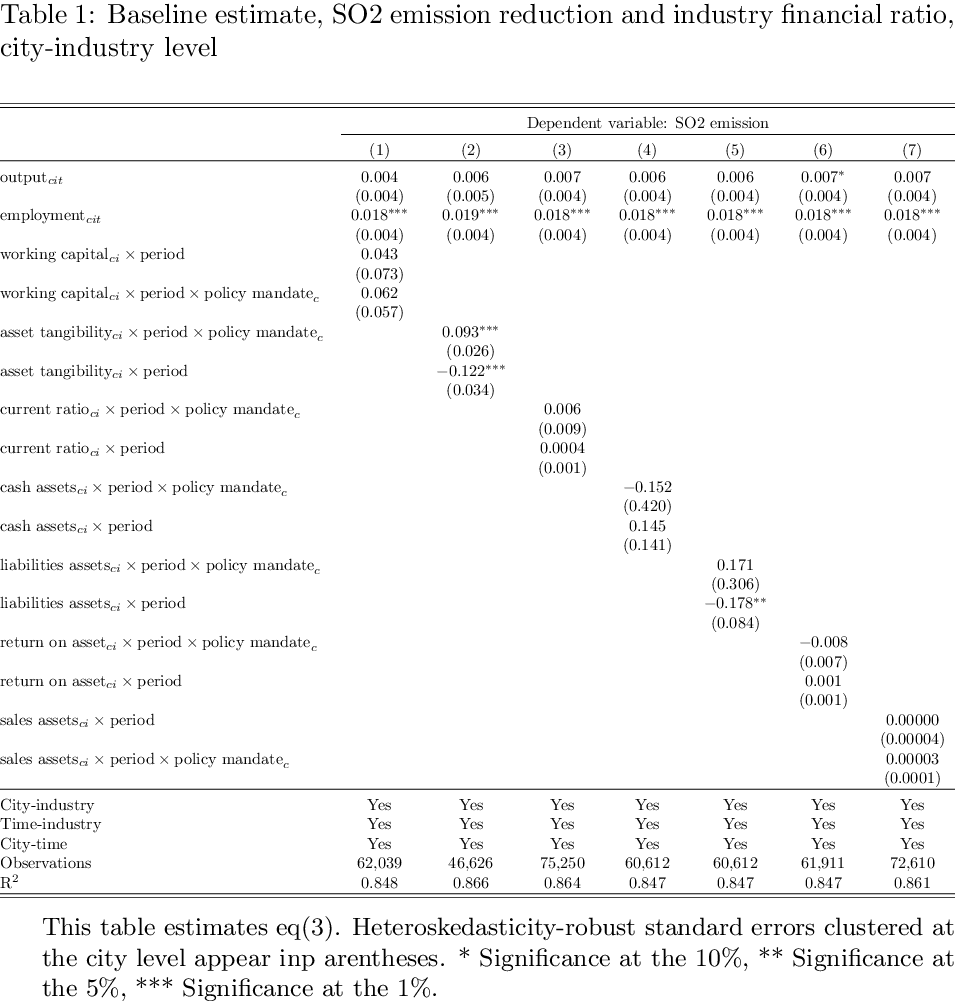

In [38]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

reorder = {
    # Old, New
    9:3, ## Working capital
    10:4, ## Asset tangibility
    11:6, ## current ratio
    12:8, ## cash asset
    13:10, ## liabilities asset
    14:12, ## return on asset
}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = 1,
            reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200)

## Table 3: Baseline estimate, SO2 emission reduction and industry financial ratio, city-industry-year level

$$
\begin{aligned}
\text{SO2}_{cit}  &= \alpha \text{Financial ratio}_cit \times \text{Period} \times \text{policy mandate}_c  + \gamma_{ci} + \gamma_{ti} +\gamma_{ct}  + \epsilon_{cit}
\end{aligned}
$$
  

In [22]:
t_0 <- felm(log(tso2) ~ working_capital_cit * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
#t_1 <- felm(log(tso2) ~ asset_tangibility_cit * period * tso2_mandate_c +
#            output + employment 
#            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
#            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ current_ratio_cit * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~ cash_assets_cit * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ liabilities_assets_cit * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~ return_on_asset_cit * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_6 <- felm(log(tso2) ~ sales_assets_cit * period * tso2_mandate_c +
            output + employment 
            | fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

In [23]:
import os
try:
    os.remove("Tables/table_2.txt")
except:
    pass
try:
    os.remove("Tables/table_2.tex")
except:
    pass
try:
    os.remove("Tables/table_2.pdf")
except:
    pass

In [24]:
dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    
    c("City-time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_2, t_3, t_4, t_5, t_6
),
    title="Baseline estimate, SO2 emission reduction and industry financial ratio, city-industry-year level",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name="Tables/table_2.txt"
)

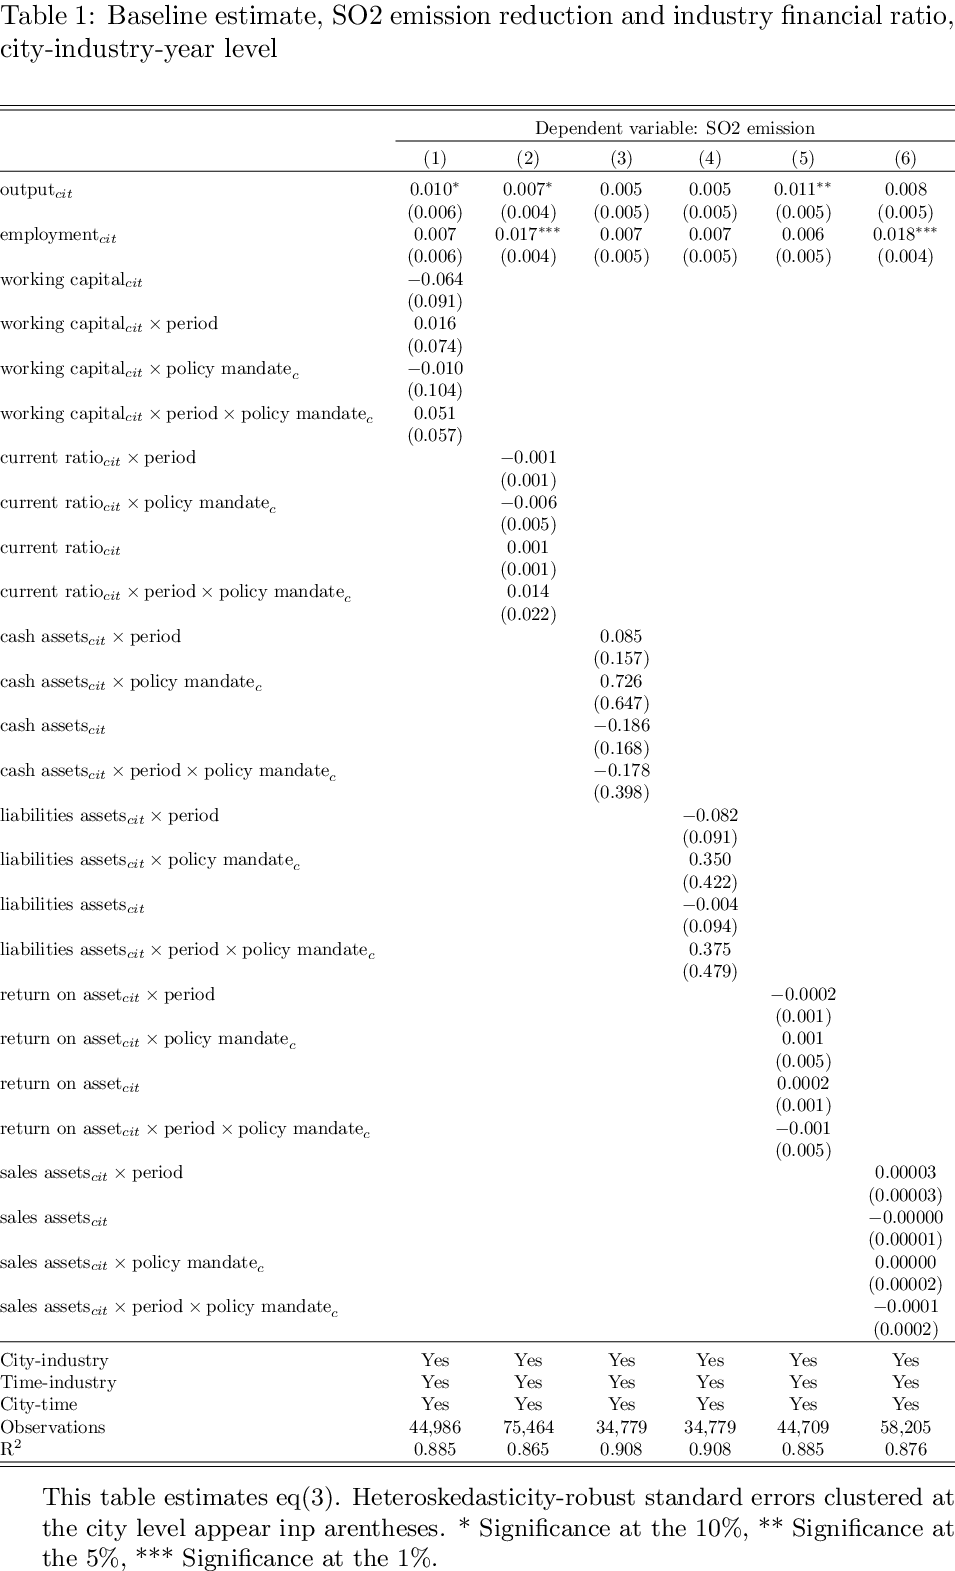

In [144]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

reorder = {
    6:0,
    7:1,
    ## Working capital
    0:2,
    20:5,
    ## current ratio
    1:8,
    21:9,
    ## cash asset
    2:12,
    22:13,
    ## liabilitis asset
    3:16,
    23:17,
    ## Retun asset
    4:20,
    24:21,
    ## Sales asset
    5:23,

}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = 2,
            reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200)

# Generate reports

In [145]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [146]:
def create_report(extension = "html", keep_code = False):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            pass  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = True)